In [1]:
import numpy as np

import torch
import torch.nn as nn

from models import CentroidGenerator
from models import DeltaEncoderGenerator
from models import AugGenerator
from models import Classifier
from dataloader import BatchLoader
from scores import AccuracyScore

import pickle as pkl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Basic train

In [2]:
X_test = torch.zeros((5, 600, 2048), dtype=torch.float32, device=device)
y_test = torch.zeros((5, 600), dtype=torch.long, device=device)
for i in range(5):
    with open('Data/PickledClasses/' + str(95 + i), 'rb') as f:
        class_data = pkl.load(f)
    X_test[i] = class_data['features']
for i in range(5):
    y_test[i] = i * torch.ones(600, dtype=torch.long, device=device)

with open('Data/PickledClasses/Merged', 'wb') as f:
    pkl.dump({'data': X_test.reshape(-1, 2048), 'labels': y_test.reshape(-1)}, f)

acc_loader = BatchLoader(class_size=600, num_classes=5, batch_size=100,
                         shuffle=False, RAM=True, data=X_test.reshape(-1, 2048), labels=y_test.reshape(-1))

In [88]:
class Classyfier(nn.Module):
    def __init__(self):
        fc_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(1024),
            nn.Linear(256, 5),
            nn.Softmax(dim=1)
        )
        super(Classyfier, self).__init__()
        self.fc = fc_layers
        
    def forward(self, x):
        out = self.fc(x)
        return out

In [60]:
create_episode(1)
create_piles(1024, 1024, 1)

In [661]:
loader = create_loader(128, 1024, 512 + 504, 1)

In [127]:
loader = reshuffle(128, 1024, 0)

In [64]:
num_iters = 4
accs = np.zeros(num_iters)
for j in range(num_iters):
    classifier = Classifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)

    acc_record = 0
    for epoch in range(20):
        for i in range(loader.train_size // loader.batch_size):
            images, labels = loader.batch_load(i)

            optimizer.zero_grad()
            predict = classifier(images)
            loss = criterion(predict, labels)
            loss.backward()
            optimizer.step()
        if (epoch % 2 == 0):
            acc = AccuracyScore(classifier, acc_loader)
            acc_record = max(acc, acc_record)

    accs[j] = acc_record
print('Accuracy on FSL task = {} %'.format(accs.mean()))

Accuracy on FSL task = 54.0 %


In [177]:
classifier = Classifier().to(device) # y !
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.00001)

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [184]:
for epoch in range(10):
    for i in range(loader.train_size // loader.batch_size):
        images, labels = loader.batch_load(i)
        
        optimizer.zero_grad()
        predict = classifier(images)
        loss = criterion(predict, labels)
        loss.backward()
        optimizer.step()
        
        loss_value = loss.detach()
    
    print('Epoch {} Loss = {}'.format(epoch, loss_value))

Epoch 0 Loss = 1.3196130990982056
Epoch 1 Loss = 1.3178027868270874
Epoch 2 Loss = 1.316072940826416
Epoch 3 Loss = 1.3144192695617676
Epoch 4 Loss = 1.3128372430801392
Epoch 5 Loss = 1.3113226890563965
Epoch 6 Loss = 1.3098716735839844
Epoch 7 Loss = 1.3084808588027954
Epoch 8 Loss = 1.3071467876434326
Epoch 9 Loss = 1.3058665990829468


In [185]:
correct = 0
total = 0
for i in range(acc_loader.train_size // acc_loader.batch_size):
    images, labels = acc_loader.batch_load(i)
        
    predict = classifier(images)
    _, predicted = torch.max(predict.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total
print('Accuracy on FSL task = {} %'.format(accuracy))

Accuracy on FSL task = 49 %


# Generate and merge in RAM

In [5]:
def create_episode(num_shots):
    episode = torch.zeros(1, 5, num_shots, 2048, requires_grad=False)
    episode_ims = np.zeros((1, 5, num_shots, 3, 84, 84), dtype=np.uint8)
    for i in range(5):
        shot_numbers = np.random.permutation(600)[:num_shots]
        
        with open('Data/PickledClasses/' + str(95 + i), 'rb') as f:
            data = pkl.load(f)
        episode[0][i][:num_shots] = data['features'][shot_numbers]
        
        with open('Data/PickledIms/' + str(95 + i), 'rb') as f:
            data = pkl.load(f)
        episode_ims[0][i][:num_shots] = data[shot_numbers]
        
    return episode, episode_ims

episode, episode_ims = create_episode(5)
episode_ims.shape

(1, 5, 5, 3, 84, 84)

In [3]:
G1 = CentroidGenerator().to(device)
G1.load_state_dict(torch.load('ModelGraphs/CentroidGenerator'))

G2 = DeltaEncoderGenerator(2048, 8192, 16).to(device)
G2.load_state_dict(torch.load('ModelGraphs/DEGenerator'))

G3 = AugGenerator(1024)

with open('Data/SynthMaterial/Centroid', 'rb') as f:
    package1 = pkl.load(f)
    
with open('Data/SynthMaterial/DE', 'rb') as f:
    package2 = pkl.load(f)

In [4]:
vgg_extractor = torch.load('ModelGraphs/VGG16Backbone', map_location=device) # on gpu

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing t

In [6]:
num_samples = 1024
X = torch.zeros((5, num_samples, 2048), device=device, requires_grad=False)
y = torch.zeros((5, 1024), device=device, requires_grad=False, dtype=torch.long)
for i in range(5):
    y[i] = i * torch.ones(1024, device=device, requires_grad=False, dtype=torch.long)
features = np.zeros((num_samples, 2048), dtype=np.float32)

X_centroid = torch.zeros((5, num_samples, 2048))
X_de = torch.zeros((5, num_samples, 2048))
X_aug_im = torch.zeros((5, 128, 3, 224, 224), dtype=torch.float32)
X_aug = torch.zeros((5, 128, 2048), dtype=torch.float32)

def create_piles(batch_size, num_samples, num_shots):
    c1_b = torch.zeros((batch_size, 2048), device=device)    
    Y1 = torch.zeros((batch_size, 2048), device=device)
    for class_num in range(5):
        if num_shots == 1:
            c1_b[:] = episode[0][class_num][0]
            Y1[:] = episode[0][class_num][0]
        else:
            idx = np.arange(batch_size) % 5
            c1_b = episode[0][class_num][idx]
            Y1 = episode[0][class_num][idx]

        features = package1['features'][:, np.random.permutation(np.arange(class_num * num_samples, (class_num + 1) * num_samples))]
        for i in range(num_samples // batch_size):
            c1_a = torch.tensor(features[0, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)
            c2_a = torch.tensor(features[1, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)

            c2_b_predict = G1(c1_a, c2_a, c1_b)
            X_centroid[class_num][i * batch_size:(i + 1) * batch_size] = c2_b_predict.detach().cpu()

        features = package2['features'][class_num][:, np.random.permutation(num_samples)]
        for i in range(num_samples // batch_size):
            X1 = torch.tensor(features[0, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)
            X2 = torch.tensor(features[1, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)

            Y2_predict = G2(X1, X2, Y1)
            X_de[class_num][i * batch_size:(i + 1) * batch_size] = Y2_predict.detach().cpu()
        
        G3.reshuffle()
        for i in range(128):
            X_aug_im[class_num][i] = G3.aug(episode_ims[0][class_num][i % num_shots], i)
        for i in range(128 // batch_size):
            X_aug[class_num, i * batch_size:(i + 1) * batch_size] = vgg_extractor(X_aug_im[class_num,
                                                                                           i * batch_size:(i + 1) * batch_size].to(device)).detach().cpu()


def reshuffle(n, n3, n2):
    X[:, :n3] = X_aug[:, :n3].to(device)
    X[:, n3:n3 + n2] = X_de[:, n3:n3 + n2].to(device)
    X[:, n3 + n2:] = X_centroid[:, n3 + n2:].to(device)

    return BatchLoader(1024, 5, batch_size=128, shuffle=True,
                       RAM=True, data=X.reshape(-1, 2048), labels=y.reshape(-1))

# Search proportion

In [206]:
num_iters = 16
num_offsets = 1
num_episodes = 32
offsets = np.array([-512], dtype=int)
accuracies = np.zeros((num_offsets, num_episodes, num_iters))

for num_offset in range(num_offsets):
    
    for num_episode in range(num_episodes):
        episode = create_episode(1)
        create_piles(1024, 1024, 1)
        loader = reshuffle(128, 1024, 512 + offsets[num_offset])
        # loader = create_loader(128, 1024, 512 + offsets[num_offset])

        for j in range(num_iters):
            classifier = Classifier().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
            
            acc_record = 0
            for epoch in range(30):
                for i in range(loader.train_size // loader.batch_size):
                    images, labels = loader.batch_load(i)

                    optimizer.zero_grad()
                    predict = classifier(images)
                    loss = criterion(predict, labels)
                    loss.backward()
                    optimizer.step()
                if (epoch % 2 == 0):
                    acc = AccuracyScore(classifier, acc_loader)
                    acc_record = max(acc, acc_record)

            accuracies[num_offset][num_episode][j] = acc_record
            
        print('  Episode {}. Mean accuracy {} %'.format(num_episode, accuracies[num_offset][num_episode].mean()))

    print(' Offset {}. Mean accuracy {} %'.format(offsets[num_offset], accuracies[num_offset].mean()))
print('\nTotal mean accuracy = {} %'.format(accuracies.mean()))
# np.save('accsOffs.npy', accuracies)

  Episode 0. Mean accuracy 69.5 %
  Episode 1. Mean accuracy 62.3125 %
  Episode 2. Mean accuracy 73.3125 %
  Episode 3. Mean accuracy 66.75 %
  Episode 4. Mean accuracy 54.3125 %
  Episode 5. Mean accuracy 56.75 %
  Episode 6. Mean accuracy 65.875 %
  Episode 7. Mean accuracy 60.0625 %
  Episode 8. Mean accuracy 63.125 %
  Episode 9. Mean accuracy 68.75 %
  Episode 10. Mean accuracy 65.1875 %
  Episode 11. Mean accuracy 61.3125 %
  Episode 12. Mean accuracy 67.125 %
  Episode 13. Mean accuracy 66.4375 %
  Episode 14. Mean accuracy 51.6875 %
  Episode 15. Mean accuracy 66.125 %
  Episode 16. Mean accuracy 64.125 %
  Episode 17. Mean accuracy 68.125 %
  Episode 18. Mean accuracy 65.4375 %
  Episode 19. Mean accuracy 53.875 %
  Episode 20. Mean accuracy 66.3125 %
  Episode 21. Mean accuracy 67.5 %
  Episode 22. Mean accuracy 66.4375 %
  Episode 23. Mean accuracy 65.8125 %
  Episode 24. Mean accuracy 61.5 %
  Episode 25. Mean accuracy 60.0625 %
  Episode 26. Mean accuracy 45.625 %
  Episo

In [8]:
iters = 16
offs_aug = 16
episodes = 20
offsets = [np.arange(8) * ((1024 - 8 * i) // 8) for i in range(16)]# [np.arange(128 - i) * 8 for i in range(16)]
accs = [np.zeros((8, episodes, iters)) for i in range(offs_aug)]


for offs1 in range(offs_aug):
    for offs2 in range(8):
        
        for i in range(episodes):    
            episode, episode_ims = create_episode(1)
            create_piles(1024, 1024, 1)
            loader = reshuffle(1024, offs1 * 8, offsets[offs1][offs2])
            
            accs[offs1][offs2][i] = validate(loader, iters)

            print('   Episode {}. Mean accuracy {} %'.format(i, accs[offs1][offs2][i].mean()))
            
        print('  Aug offset {}. Offset {}. Mean accuracy {} %'.format(offs1 * 8, offsets[offs1][offs2],
                                                                      accs[offs1][offs2].mean()))
    print(' Aug offset {}. Mean accuracy = {} %'.format(offs1 * 8, accs[offs1].mean()))

   Episode 0. Mean accuracy 56.308332204818726 %
   Episode 1. Mean accuracy 44.34583282470703 %
   Episode 2. Mean accuracy 58.11249899864197 %
   Episode 3. Mean accuracy 59.554166078567505 %
   Episode 4. Mean accuracy 52.38541603088379 %
   Episode 5. Mean accuracy 52.68541598320007 %
   Episode 6. Mean accuracy 53.46458292007446 %
   Episode 7. Mean accuracy 45.25624966621399 %
   Episode 8. Mean accuracy 56.10416626930237 %
   Episode 9. Mean accuracy 69.13333320617676 %
   Episode 10. Mean accuracy 67.09583282470703 %
   Episode 11. Mean accuracy 67.26874947547913 %
   Episode 12. Mean accuracy 67.77500033378601 %
   Episode 13. Mean accuracy 57.87291646003723 %
   Episode 14. Mean accuracy 69.34583282470703 %
   Episode 15. Mean accuracy 63.90416646003723 %
   Episode 16. Mean accuracy 62.2937490940094 %
   Episode 17. Mean accuracy 63.96041560173035 %
   Episode 18. Mean accuracy 52.210416316986084 %
   Episode 19. Mean accuracy 63.247915744781494 %
  Aug offset 0. Offset 0. M

   Episode 0. Mean accuracy 49.710416316986084 %
   Episode 1. Mean accuracy 56.1062490940094 %
   Episode 2. Mean accuracy 64.27708339691162 %
   Episode 3. Mean accuracy 49.960415840148926 %
   Episode 4. Mean accuracy 44.90416669845581 %
   Episode 5. Mean accuracy 60.395833253860474 %
   Episode 6. Mean accuracy 66.15624928474426 %
   Episode 7. Mean accuracy 57.97499942779541 %
   Episode 8. Mean accuracy 66.1479160785675 %
   Episode 9. Mean accuracy 54.47291564941406 %
   Episode 10. Mean accuracy 61.34374952316284 %
   Episode 11. Mean accuracy 57.1333327293396 %
   Episode 12. Mean accuracy 62.804166078567505 %
   Episode 13. Mean accuracy 72.67916536331177 %
   Episode 14. Mean accuracy 63.44166660308838 %
   Episode 15. Mean accuracy 64.96249961853027 %
   Episode 16. Mean accuracy 61.1062490940094 %
   Episode 17. Mean accuracy 58.88541603088379 %
   Episode 18. Mean accuracy 67.18749809265137 %
   Episode 19. Mean accuracy 73.86041593551636 %
  Aug offset 8. Offset 0. Mean

   Episode 0. Mean accuracy 50.52708292007446 %
   Episode 1. Mean accuracy 64.45624995231628 %
   Episode 2. Mean accuracy 67.51666641235352 %
   Episode 3. Mean accuracy 59.6062490940094 %
   Episode 4. Mean accuracy 61.516666412353516 %
   Episode 5. Mean accuracy 55.65624952316284 %
   Episode 6. Mean accuracy 51.68958282470703 %
   Episode 7. Mean accuracy 69.2791657447815 %
   Episode 8. Mean accuracy 72.53124952316284 %
   Episode 9. Mean accuracy 66.1458330154419 %
   Episode 10. Mean accuracy 52.39166617393494 %
   Episode 11. Mean accuracy 62.81458306312561 %
   Episode 12. Mean accuracy 57.62499928474426 %
   Episode 13. Mean accuracy 68.66666531562805 %
   Episode 14. Mean accuracy 57.64374923706055 %
   Episode 15. Mean accuracy 64.36041569709778 %
   Episode 16. Mean accuracy 66.9708321094513 %
   Episode 17. Mean accuracy 62.00208282470703 %
   Episode 18. Mean accuracy 68.19999814033508 %
   Episode 19. Mean accuracy 63.99583339691162 %
  Aug offset 16. Offset 0. Mean a

   Episode 0. Mean accuracy 66.6791660785675 %
   Episode 1. Mean accuracy 72.50416469573975 %
   Episode 2. Mean accuracy 45.62499928474426 %
   Episode 3. Mean accuracy 61.72291588783264 %
   Episode 4. Mean accuracy 67.34583306312561 %
   Episode 5. Mean accuracy 62.56458234786987 %
   Episode 6. Mean accuracy 55.6916663646698 %
   Episode 7. Mean accuracy 61.47916603088379 %
   Episode 8. Mean accuracy 61.66249990463257 %
   Episode 9. Mean accuracy 53.37083292007446 %
   Episode 10. Mean accuracy 63.62083339691162 %
   Episode 11. Mean accuracy 50.343749046325684 %
   Episode 12. Mean accuracy 60.62708282470703 %
   Episode 13. Mean accuracy 51.61874961853027 %
   Episode 14. Mean accuracy 44.22708296775818 %
   Episode 15. Mean accuracy 48.03749918937683 %
   Episode 16. Mean accuracy 66.93541646003723 %
   Episode 17. Mean accuracy 65.88541579246521 %
   Episode 18. Mean accuracy 68.14583277702332 %
   Episode 19. Mean accuracy 59.802082538604736 %
  Aug offset 24. Offset 0. Mea

   Episode 0. Mean accuracy 69.4229166507721 %
   Episode 1. Mean accuracy 60.22708296775818 %
   Episode 2. Mean accuracy 62.59166669845581 %
   Episode 3. Mean accuracy 60.22499918937683 %
   Episode 4. Mean accuracy 62.456249475479126 %
   Episode 5. Mean accuracy 64.03541564941406 %
   Episode 6. Mean accuracy 58.056249380111694 %
   Episode 7. Mean accuracy 49.63749933242798 %
   Episode 8. Mean accuracy 52.902082681655884 %
   Episode 9. Mean accuracy 65.77083206176758 %
   Episode 10. Mean accuracy 72.8937497138977 %
   Episode 11. Mean accuracy 61.6687490940094 %
   Episode 12. Mean accuracy 50.01249957084656 %
   Episode 13. Mean accuracy 53.95416593551636 %
   Episode 14. Mean accuracy 63.48124980926514 %
   Episode 15. Mean accuracy 69.22708320617676 %
   Episode 16. Mean accuracy 52.98541617393494 %
   Episode 17. Mean accuracy 55.49999976158142 %
   Episode 18. Mean accuracy 65.92499923706055 %
   Episode 19. Mean accuracy 60.43333292007446 %
  Aug offset 32. Offset 0. Mea

   Episode 0. Mean accuracy 72.37083172798157 %
   Episode 1. Mean accuracy 65.56458282470703 %
   Episode 2. Mean accuracy 58.014583110809326 %
   Episode 3. Mean accuracy 52.47499942779541 %
   Episode 4. Mean accuracy 72.08124995231628 %
   Episode 5. Mean accuracy 70.42499899864197 %
   Episode 6. Mean accuracy 50.65833234786987 %
   Episode 7. Mean accuracy 61.564581871032715 %
   Episode 8. Mean accuracy 64.49583220481873 %
   Episode 9. Mean accuracy 53.297916412353516 %
   Episode 10. Mean accuracy 63.52916669845581 %
   Episode 11. Mean accuracy 69.47291541099548 %
   Episode 12. Mean accuracy 58.70416617393494 %
   Episode 13. Mean accuracy 72.5479154586792 %
   Episode 14. Mean accuracy 66.32916569709778 %
   Episode 15. Mean accuracy 66.38749933242798 %
   Episode 16. Mean accuracy 55.23124980926514 %
   Episode 17. Mean accuracy 55.14999985694885 %
   Episode 18. Mean accuracy 49.433332204818726 %
   Episode 19. Mean accuracy 51.520832538604736 %
  Aug offset 40. Offset 0.

   Episode 0. Mean accuracy 63.04166555404663 %
   Episode 1. Mean accuracy 60.364581823349 %
   Episode 2. Mean accuracy 72.364581823349 %
   Episode 3. Mean accuracy 57.03749942779541 %
   Episode 4. Mean accuracy 67.01874923706055 %
   Episode 5. Mean accuracy 62.24791598320007 %
   Episode 6. Mean accuracy 68.56458282470703 %
   Episode 7. Mean accuracy 57.462499380111694 %
   Episode 8. Mean accuracy 66.53749942779541 %
   Episode 9. Mean accuracy 38.31041669845581 %
   Episode 10. Mean accuracy 47.37916564941406 %
   Episode 11. Mean accuracy 73.09583282470703 %
   Episode 12. Mean accuracy 45.76041603088379 %
   Episode 13. Mean accuracy 50.63333296775818 %
   Episode 14. Mean accuracy 58.73541617393494 %
   Episode 15. Mean accuracy 65.54583239555359 %
   Episode 16. Mean accuracy 61.88333225250244 %
   Episode 17. Mean accuracy 68.98124933242798 %
   Episode 18. Mean accuracy 61.68749952316284 %
   Episode 19. Mean accuracy 61.527082204818726 %
  Aug offset 48. Offset 0. Mean 

   Episode 0. Mean accuracy 66.2791657447815 %
   Episode 1. Mean accuracy 65.02916622161865 %
   Episode 2. Mean accuracy 41.49791669845581 %
   Episode 3. Mean accuracy 71.96666669845581 %
   Episode 4. Mean accuracy 52.88958263397217 %
   Episode 5. Mean accuracy 71.34166622161865 %
   Episode 6. Mean accuracy 52.79166626930237 %
   Episode 7. Mean accuracy 61.28124928474426 %
   Episode 8. Mean accuracy 69.24791669845581 %
   Episode 9. Mean accuracy 59.589582443237305 %
   Episode 10. Mean accuracy 58.50833296775818 %
   Episode 11. Mean accuracy 49.095832109451294 %
   Episode 12. Mean accuracy 52.38124990463257 %
   Episode 13. Mean accuracy 65.42916631698608 %
   Episode 14. Mean accuracy 61.00624942779541 %
   Episode 15. Mean accuracy 64.0020821094513 %
   Episode 16. Mean accuracy 66.28124904632568 %
   Episode 17. Mean accuracy 52.72291612625122 %
   Episode 18. Mean accuracy 60.68541646003723 %
   Episode 19. Mean accuracy 63.22083234786987 %
  Aug offset 56. Offset 0. Mea

   Episode 0. Mean accuracy 68.37708258628845 %
   Episode 1. Mean accuracy 55.21666622161865 %
   Episode 2. Mean accuracy 54.581249952316284 %
   Episode 3. Mean accuracy 64.3645830154419 %
   Episode 4. Mean accuracy 61.14999985694885 %
   Episode 5. Mean accuracy 58.97083330154419 %
   Episode 6. Mean accuracy 61.85624980926514 %
   Episode 7. Mean accuracy 56.206249475479126 %
   Episode 8. Mean accuracy 61.335415840148926 %
   Episode 9. Mean accuracy 59.04999899864197 %
   Episode 10. Mean accuracy 69.36666560173035 %
   Episode 11. Mean accuracy 57.20208263397217 %
   Episode 12. Mean accuracy 67.43124985694885 %
   Episode 13. Mean accuracy 72.67916631698608 %
   Episode 14. Mean accuracy 48.92291593551636 %
   Episode 15. Mean accuracy 63.77291655540466 %
   Episode 16. Mean accuracy 52.46666646003723 %
   Episode 17. Mean accuracy 58.78541660308838 %
   Episode 18. Mean accuracy 64.31249904632568 %
   Episode 19. Mean accuracy 60.85416555404663 %
  Aug offset 64. Offset 0. M

   Episode 0. Mean accuracy 69.5166654586792 %
   Episode 1. Mean accuracy 55.02291655540466 %
   Episode 2. Mean accuracy 66.69583225250244 %
   Episode 3. Mean accuracy 63.83749842643738 %
   Episode 4. Mean accuracy 59.86874961853027 %
   Episode 5. Mean accuracy 57.15208292007446 %
   Episode 6. Mean accuracy 70.2395830154419 %
   Episode 7. Mean accuracy 69.59999942779541 %
   Episode 8. Mean accuracy 62.72291612625122 %
   Episode 9. Mean accuracy 59.710416078567505 %
   Episode 10. Mean accuracy 66.40416622161865 %
   Episode 11. Mean accuracy 57.72083282470703 %
   Episode 12. Mean accuracy 55.86041569709778 %
   Episode 13. Mean accuracy 67.64999961853027 %
   Episode 14. Mean accuracy 60.802082777023315 %
   Episode 15. Mean accuracy 52.274999380111694 %
   Episode 16. Mean accuracy 62.656248807907104 %
   Episode 17. Mean accuracy 52.333332777023315 %
   Episode 18. Mean accuracy 64.69166684150696 %
   Episode 19. Mean accuracy 63.641666412353516 %
  Aug offset 72. Offset 0.

   Episode 0. Mean accuracy 61.991666078567505 %
   Episode 1. Mean accuracy 69.29583239555359 %
   Episode 2. Mean accuracy 52.204166650772095 %
   Episode 3. Mean accuracy 56.32708263397217 %
   Episode 4. Mean accuracy 46.15833306312561 %
   Episode 5. Mean accuracy 56.60416603088379 %
   Episode 6. Mean accuracy 47.50833249092102 %
   Episode 7. Mean accuracy 70.70624899864197 %
   Episode 8. Mean accuracy 71.89791655540466 %
   Episode 9. Mean accuracy 58.174999475479126 %
   Episode 10. Mean accuracy 68.59583258628845 %
   Episode 11. Mean accuracy 59.97083234786987 %
   Episode 12. Mean accuracy 65.11666655540466 %
   Episode 13. Mean accuracy 70.28958225250244 %
   Episode 14. Mean accuracy 65.95208215713501 %
   Episode 15. Mean accuracy 67.89166593551636 %
   Episode 16. Mean accuracy 46.59791588783264 %
   Episode 17. Mean accuracy 57.968749046325684 %
   Episode 18. Mean accuracy 62.11041593551636 %
   Episode 19. Mean accuracy 66.7083330154419 %
  Aug offset 80. Offset 0. 

   Episode 0. Mean accuracy 67.77083206176758 %
   Episode 1. Mean accuracy 52.50624966621399 %
   Episode 2. Mean accuracy 55.34791612625122 %
   Episode 3. Mean accuracy 56.71874928474426 %
   Episode 4. Mean accuracy 61.799999475479126 %
   Episode 5. Mean accuracy 63.76041579246521 %
   Episode 6. Mean accuracy 62.63124918937683 %
   Episode 7. Mean accuracy 64.91458249092102 %
   Episode 8. Mean accuracy 51.52916598320007 %
   Episode 9. Mean accuracy 63.26249980926514 %
   Episode 10. Mean accuracy 62.31666707992554 %
   Episode 11. Mean accuracy 61.88958287239075 %
   Episode 12. Mean accuracy 59.027082443237305 %
   Episode 13. Mean accuracy 58.26666617393494 %
   Episode 14. Mean accuracy 67.7479157447815 %
   Episode 15. Mean accuracy 59.802082538604736 %
   Episode 16. Mean accuracy 70.46458292007446 %
   Episode 17. Mean accuracy 60.34791564941406 %
   Episode 18. Mean accuracy 58.17291593551636 %
   Episode 19. Mean accuracy 54.21666669845581 %
  Aug offset 88. Offset 0. M

   Episode 0. Mean accuracy 64.97291612625122 %
   Episode 1. Mean accuracy 69.41458320617676 %
   Episode 2. Mean accuracy 59.15833306312561 %
   Episode 3. Mean accuracy 43.466665744781494 %
   Episode 4. Mean accuracy 59.98749899864197 %
   Episode 5. Mean accuracy 58.35208225250244 %
   Episode 6. Mean accuracy 68.78125023841858 %
   Episode 7. Mean accuracy 72.1104154586792 %
   Episode 8. Mean accuracy 67.8916654586792 %
   Episode 9. Mean accuracy 63.00416612625122 %
   Episode 10. Mean accuracy 62.14791560173035 %
   Episode 11. Mean accuracy 55.10833263397217 %
   Episode 12. Mean accuracy 56.210416316986084 %
   Episode 13. Mean accuracy 56.17499923706055 %
   Episode 14. Mean accuracy 60.80208230018616 %
   Episode 15. Mean accuracy 60.95208239555359 %
   Episode 16. Mean accuracy 59.520832538604736 %
   Episode 17. Mean accuracy 51.59374928474426 %
   Episode 18. Mean accuracy 68.74374985694885 %
   Episode 19. Mean accuracy 59.527082681655884 %
  Aug offset 96. Offset 0. M

   Episode 0. Mean accuracy 64.91666603088379 %
   Episode 1. Mean accuracy 72.59374952316284 %
   Episode 2. Mean accuracy 62.13749980926514 %
   Episode 3. Mean accuracy 63.22083258628845 %
   Episode 4. Mean accuracy 54.06874918937683 %
   Episode 5. Mean accuracy 65.80208230018616 %
   Episode 6. Mean accuracy 51.489582538604736 %
   Episode 7. Mean accuracy 55.41458296775818 %
   Episode 8. Mean accuracy 50.04999923706055 %
   Episode 9. Mean accuracy 53.516666412353516 %
   Episode 10. Mean accuracy 60.25624942779541 %
   Episode 11. Mean accuracy 59.09374928474426 %
   Episode 12. Mean accuracy 50.90416598320007 %
   Episode 13. Mean accuracy 67.53541612625122 %
   Episode 14. Mean accuracy 64.20000004768372 %
   Episode 15. Mean accuracy 67.58124947547913 %
   Episode 16. Mean accuracy 56.60624933242798 %
   Episode 17. Mean accuracy 42.579166412353516 %
   Episode 18. Mean accuracy 53.677083015441895 %
   Episode 19. Mean accuracy 73.2541651725769 %
  Aug offset 104. Offset 0.

   Episode 0. Mean accuracy 50.804165840148926 %
   Episode 1. Mean accuracy 61.935415267944336 %
   Episode 2. Mean accuracy 57.427082777023315 %
   Episode 3. Mean accuracy 53.395833015441895 %
   Episode 4. Mean accuracy 67.79791641235352 %
   Episode 5. Mean accuracy 54.94374942779541 %
   Episode 6. Mean accuracy 54.40624952316284 %
   Episode 7. Mean accuracy 52.70416569709778 %
   Episode 8. Mean accuracy 68.18124914169312 %
   Episode 9. Mean accuracy 41.21666646003723 %
   Episode 10. Mean accuracy 64.29583311080933 %
   Episode 11. Mean accuracy 50.29583287239075 %
   Episode 12. Mean accuracy 53.52916646003723 %
   Episode 13. Mean accuracy 55.00208282470703 %
   Episode 14. Mean accuracy 59.116665840148926 %
   Episode 15. Mean accuracy 70.02083277702332 %
   Episode 16. Mean accuracy 66.92083239555359 %
   Episode 17. Mean accuracy 59.71874976158142 %
   Episode 18. Mean accuracy 56.5708327293396 %
   Episode 19. Mean accuracy 45.614583253860474 %
  Aug offset 112. Offset 

   Episode 0. Mean accuracy 67.3166663646698 %
   Episode 1. Mean accuracy 58.208333015441895 %
   Episode 2. Mean accuracy 66.05208277702332 %
   Episode 3. Mean accuracy 52.185415744781494 %
   Episode 4. Mean accuracy 60.78749966621399 %
   Episode 5. Mean accuracy 64.17708373069763 %
   Episode 6. Mean accuracy 60.087499380111694 %
   Episode 7. Mean accuracy 48.25208282470703 %
   Episode 8. Mean accuracy 60.11041569709778 %
   Episode 9. Mean accuracy 53.139583110809326 %
   Episode 10. Mean accuracy 67.09791588783264 %
   Episode 11. Mean accuracy 59.831249475479126 %
   Episode 12. Mean accuracy 63.85833287239075 %
   Episode 13. Mean accuracy 62.94999980926514 %
   Episode 14. Mean accuracy 62.65208339691162 %
   Episode 15. Mean accuracy 59.895832538604736 %
   Episode 16. Mean accuracy 59.53124928474426 %
   Episode 17. Mean accuracy 59.94791603088379 %
   Episode 18. Mean accuracy 59.97083306312561 %
   Episode 19. Mean accuracy 63.56041646003723 %
  Aug offset 120. Offset 

In [7]:
def validate(loader, num_iters):
    accs = np.zeros(num_iters)
    for j in range(num_iters):
        classifier = Classifier().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)

        acc_record = 0
        for epoch in range(20):
            for i in range(loader.train_size // loader.batch_size):
                images, labels = loader.batch_load(i)

                optimizer.zero_grad()
                predict = classifier(images.to(device))
                loss = criterion(predict, labels.to(device))
                loss.backward()
                optimizer.step()
            if (epoch % 2 == 0):
                acc = AccuracyScore(classifier, acc_loader)
                acc_record = max(acc, acc_record)
        accs[j] = acc_record
    return accs

In [9]:
np.save('Accs/4/accs1.npy', np.array(accs))

# Save section

In [3]:
accs_str = str(input())

   Episode 0. Mean accuracy 52.268749713897705 %    Episode 1. Mean accuracy 60.056249380111694 %    Episode 2. Mean accuracy 51.858333349227905 %    Episode 3. Mean accuracy 59.327083110809326 %    Episode 4. Mean accuracy 69.98124933242798 %    Episode 5. Mean accuracy 45.239582538604736 %    Episode 6. Mean accuracy 60.677082538604736 %    Episode 7. Mean accuracy 61.020833015441895 %    Episode 8. Mean accuracy 48.88124918937683 %    Episode 9. Mean accuracy 65.85416603088379 %    Episode 10. Mean accuracy 61.04583287239075 %    Episode 11. Mean accuracy 49.48749923706055 %    Episode 12. Mean accuracy 54.50208258628845 %    Episode 13. Mean accuracy 68.55208158493042 %    Episode 14. Mean accuracy 47.19791626930237 %    Episode 15. Mean accuracy 60.78333306312561 %    Episode 16. Mean accuracy 42.08958292007446 %    Episode 17. Mean accuracy 50.70208287239075 %    Episode 18. Mean accuracy 56.60833263397217 %    Episode 19. Mean accuracy 64.57291579246521 %    Episode 20. Mean acc

In [5]:
accs = accs_str.split('%')
# accs.insert(491, '   Episode 29. Mean accuracy 69.2734375 ')
accs = np.array([accs[i].split(' ')[8] for i in range(len(accs) - 1)])
accs[0] = '52.268749713897705'
# accs = np.delete(accs, '')
accs = accs.reshape(-1, 33)
accs = np.array(accs[:, :32], dtype=float)
# np.save('accsOffsDE.npy', accs)
accs

array([[52.26874971, 60.05624938, 51.85833335, 59.32708311, 69.98124933,
        45.23958254, 60.67708254, 61.02083302, 48.88124919, 65.85416603,
        61.04583287, 49.48749924, 54.50208259, 68.55208158, 47.19791627,
        60.78333306, 42.08958292, 50.70208287, 56.60833263, 64.57291579,
        65.84583306, 53.13333297, 63.96666622, 63.46874905, 68.31666636,
        58.2562499 , 57.06874943, 62.87499976, 45.69791627, 61.3374989 ,
        57.16874886, 54.99166632],
       [59.51458287, 53.44166613, 68.48958182, 66.7958324 , 50.07916641,
        57.41458344, 56.81874919, 65.72083259, 66.18541574, 73.53124809,
        58.07291603, 66.50624943, 61.63333249, 50.31041622, 62.57083273,
        72.13541508, 60.4937489 , 57.47708225, 67.68749928, 53.53958321,
        69.27291632, 63.04374933, 64.17291546, 55.00208282, 73.39999962,
        66.41666579, 55.39166617, 51.86249924, 73.66666627, 63.28958273,
        64.04791522, 57.98958278],
       [78.28124905, 63.86249924, 70.39999866, 55.1979

In [11]:
accs0 = np.load('Accs/2/accsOffsFull.npy')
accs = np.concatenate((accs0, accs), axis=0)
# np.save('Accs/accsOffsCentr.npy', accs)

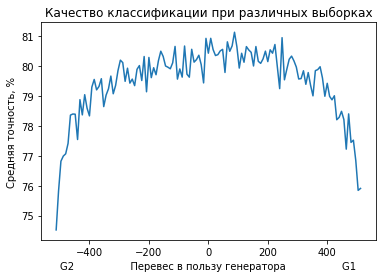

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Качество классификации при различных выборках')
plt.xlabel('G2                  Перевес в пользу генератора                  G1')
plt.ylabel('Средняя точность, %')
plt.plot(np.arange(-64, 65) * 8, np.flip(accs.mean(axis=1)))
plt.savefig('2.png')

In [49]:
accs = np.load('Accs/2/accsOffsFull5shot.npy')
accs.shape

(129, 32)

In [50]:
accuracies = accs.mean(axis=1)

In [48]:
accuracies[np.where(accuracies > 79.5)].mean()

80.15898753978588

In [53]:
accuracies[128]

74.517578125

In [41]:
64 - 58

6

5